# import stuff

In [1]:
%load_ext autoreload
%autoreload 2

# import python stuff
import matplotlib.pyplot as plt
import numpy as np

import scipy
import scipy.special as spe
from scipy import optimize
from scipy.stats import poisson
from qutip import *
import iminuit
import time
import multiprocessing as mp
from platform import python_version
import os

# import my functions
from functionsSqueeze import *
from functions_SpinPhonon import *

# import existing Paula funcitons
from PyModules.analyse_eios import eios_sb
from PyModules.analyse_eios import eios_analyse
from PyModules.analyse_eios import eios_data

print("python version:", python_version())
print("number of CPU's:", mp.cpu_count())

python version: 3.6.9
number of CPU's: 8


# Poisson Fits for two ions

## define poisson fit functions (equivalent funcitons to the ones for one ion in eios_analyse)

In [27]:
# def plot_hist_res_2I(hist, res):
#     xx = np.linspace(0, 30, 31)
#     mu_dd, mu_du, mu_uu = res['x'][0], res['x'][1], res['x'][2]
#     p_dd, p_du, p_uu = res['x'][3], res['x'][4], res['x'][5]
    
#     y = p_dd*poisson.pmf(xx, mu_dd) + p_du*poisson.pmf(xx, mu_du) + p_uu*poisson.pmf(xx, mu_uu)
# #     y = [(res['x'][2]+res['x'][3])*poisson.pmf(i, res['x'][0]) + (2-res['x'][2]-res['x'][3])*poisson.pmf(i, res['x'][1]) for i in xx]
    
#     plt.hist(hist, bins=range(30), rwidth=0.8, align='left', density=True)
#     plt.plot(xx, y/np.sum(y))
#     plt.show()

## do the fitting

processing time new: 0.0413


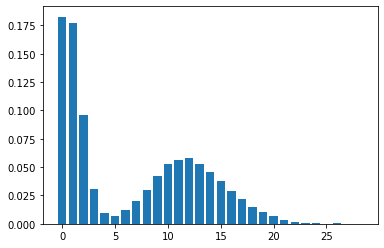

In [2]:
# check the function for my photon counts simulation funcion
t1 = time.time()
hist = rand_4Poisson_hist(0.5, 12, 0.5, 0.5, 0, repetitions=10000)
print("processing time new:", np.round( time.time()-t1, 4))

plt.hist(hist, bins=range(30), rwidth=0.8, align='left', density=True)
plt.show()

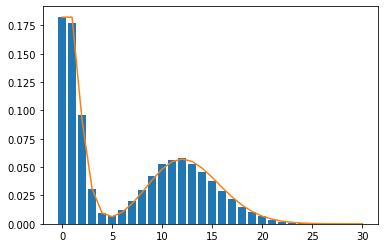

In [4]:
# manually set the pre fit
prefit = {'x': [24, 12.5, 1, 0, 0, 0]}

# fit the probability of down down, down up, up up
y_dd, y_du, y_uu,_,_,_ = eios_analyse.fit_hist_2I([hist], prefit, parallel = True)

eios_analyse.plot_hist_res_2I(hist, prefit['x'][:3], [y_dd[0], y_du[0], y_uu[0]])

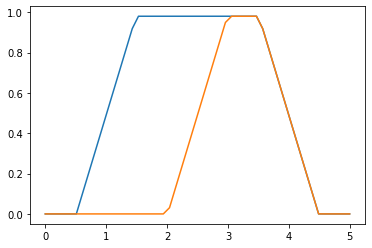

In [5]:
times = np.linspace(-0, 5, 50)

# define a simple ramp funciton
def rmp(t):
    if t <= 0.01:
        return 0.01
    elif 0.01<t<=0.99:
        return t
    else:
        return 0.99

Ps1 = np.array([rmp(t-0.5)-rmp(t-3.5) for t in times])
Ps2 = np.array([rmp(t - 2)-rmp(t-3.5) for t in times])

plt.plot(times, Ps1)
plt.plot(times, Ps2)
plt.show()

# simulate data
hists = []
for i, t in enumerate(times):
    hists.append([rand_4Poisson(0.5, 8, 0, Ps1[i], Ps2[i]) for j in range(1000)])

In [6]:
# do the prefit to determine the three count levels (with all histograms)

t1 = time.time()
prefit = eios_analyse.fit_poisson_hist_2I(hists, 0.5, 10)
print("processing time:", np.round( time.time()-t1, 4))

processing time: 2.1991


In [8]:
# do the fits to determine the population of (down, down) and (down, up) = (up, down) and (up, up)

t1 = time.time()
# y_dd, y_du, y_uu, y_err_dd, y_err_du, y_err_uu = eios_analyse.fit_hist_2I(hists, prefit, parallel = True)
y_dd, y_du, y_uu, y_err_dd, y_err_du, y_err_uu = eios_analyse.fit_hist_2I(hists, prefit, parallel = True)
print("processing time:", np.round( time.time()-t1, 4))

processing time: 0.2134


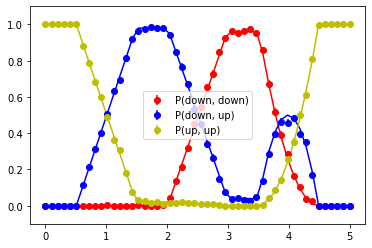

In [9]:
plt.errorbar(times, y_dd, y_err_dd, fmt = 'ro', label='P(down, down)')
plt.errorbar(times, y_du, y_err_du, fmt = 'bo', label='P(down, up)')
plt.errorbar(times, y_uu, y_err_uu, fmt = 'yo', label='P(up, up)')

# fit results
# plt.plot(times, y_dd, 'ro', label=r'P($\downarrow \downarrow$)')
# plt.plot(times, y_du, 'bo', label=r'P($\downarrow \uparrow$)')
# plt.plot(times, y_uu, 'yo', label=r'P($\uparrow \uparrow$)')

# expectation
plt.plot(times, Ps1*Ps2, 'r-') # both down
plt.plot(times, (1-Ps1)*Ps2 + Ps1*(1-Ps2), 'b-') # one down one up
plt.plot(times, (1-Ps1)*(1-Ps2), 'y-') # both up
plt.ylim((-0.1, 1.1))
plt.legend()
plt.show()

This plot shows the results of the fit routine to get the population levels P(down, down), P(up, up) and P(down, up)=P(up, down).<br/>
The dots show the fitted results, and the lines the expectation (e.g. the initial values for the data simulation). It was assumed that the simulated histogram can be fitted on a three-poissonian-distribution, but the data was simulated using a four-poissonian-distribution, with expectation values for the (down, up) state slightly different to the expectation value for the (up, down) state.

3.163265306122449
values: [0.956 0.044 0.   ]
errors: [0.011 0.011 0.001]


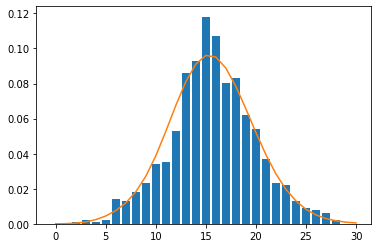

In [11]:
# plot one histogram with the fit
ii = 31

print(times[ii])

print('values:', np.round([y_dd[ii], y_du[ii], y_uu[ii]], 3))
print('errors:', np.round([y_err_dd[ii], y_err_du[ii], y_err_uu[ii]], 3))

eios_analyse.plot_hist_res_2I(hists[ii], np.flip(np.sort(prefit['x'][:3])), [y_dd[ii], y_du[ii], y_uu[ii]])

In [12]:
# eios_analyse.fit_hist_2I([hists[ii]], prefit, parallel = True)
eios_analyse.fit_hist_2I([hists[ii]], prefit, parallel = True)

([0.955655946216281],
 [0.044344053692032204],
 [9.168672468112146e-11],
 [0.010878549042333187],
 [0.010793147365653732],
 [0.0013604408227052545])

## simulate MW flop

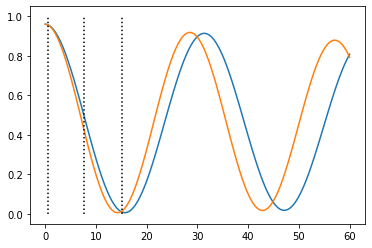

In [17]:
# simulate MW Flop
times = np.linspace(0, 60, 120)
iis = [1, 15, 30]

Ps1 = (0.48*(1+np.cos(0.2*times)) - 0.2) * np.exp(-0.002*times) + 0.2
Ps2 = (0.48*(1+np.cos(0.22*times)) - 0.21) * np.exp(-0.002*times) + 0.21

plt.plot(times, Ps1)
plt.plot(times, Ps2)
for ii in iis: plt.plot([times[ii], times[ii]], [0, 1], 'k:')
plt.show()

# simulate data
hists = []
for i, t in enumerate(times):
    hists.append([rand_4Poisson(0.5, 8, 0, Ps1[i], Ps2[i]) for j in range(200)])

In [18]:
t1 = time.time()
prefit = eios_analyse.fit_poisson_hist_2I(hists, 0.5, 10)
print("processing time:", np.round( time.time()-t1, 4))

t1 = time.time()
y_dd, y_du, y_uu, y_err_dd, y_err_du, y_err_uu = eios_analyse.fit_hist_2I(hists, prefit, parallel = True)
print("processing time:", np.round( time.time()-t1, 4))

processing time: 1.0756
processing time: 0.2464


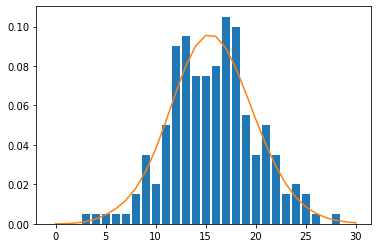

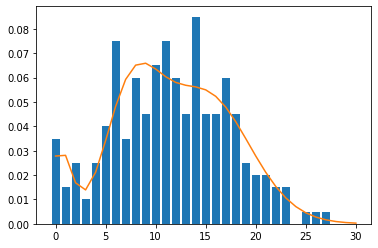

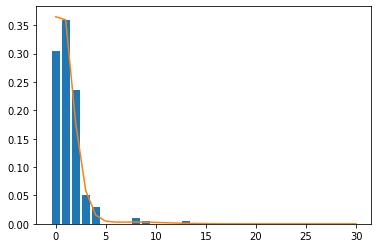

In [19]:
mus = np.flip(np.sort(prefit['x'][:3]))

for ii in [1, 10, 31]:
    eios_analyse.plot_hist_res_2I(hists[ii], mus, [y_dd[ii], y_du[ii], y_uu[ii]])

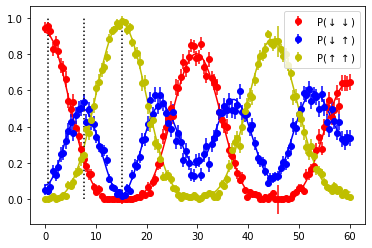

In [20]:
# fit results
plt.errorbar(times, y_dd, y_err_dd, fmt = 'ro', label=r'P($\downarrow \downarrow$)')
plt.errorbar(times, y_du, y_err_du, fmt = 'bo', label=r'P($\downarrow \uparrow$)')
plt.errorbar(times, y_uu, y_err_uu, fmt = 'yo', label=r'P($\uparrow \uparrow$)')

# expectation
plt.plot(times, Ps1*Ps2, 'r-') # both down
plt.plot(times, (1-Ps1)*Ps2 + Ps1*(1-Ps2), 'b-') # one down one up
plt.plot(times, (1-Ps1)*(1-Ps2), 'y-') # both up

for ii in iis: plt.plot([times[ii], times[ii]], [0, 1], 'k:')
plt.legend()
plt.show()